In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [9]:
import torchvision

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 10
lr = 1e-3

In [4]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


In [5]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
  def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
  def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps  # z
  def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
  def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(epochs):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.view(-1, 28*28).to(device)
    optimizer.zero_grad()
    x_recon, mu, logvar = model(data)
    loss = loss_function(x_recon, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch [1/10] Loss: 163.4670
Epoch [2/10] Loss: 121.2905
Epoch [3/10] Loss: 114.5009
Epoch [4/10] Loss: 111.5287
Epoch [5/10] Loss: 109.7229
Epoch [6/10] Loss: 108.5180
Epoch [7/10] Loss: 107.6482
Epoch [8/10] Loss: 106.9830
Epoch [9/10] Loss: 106.5428
Epoch [10/10] Loss: 106.0212


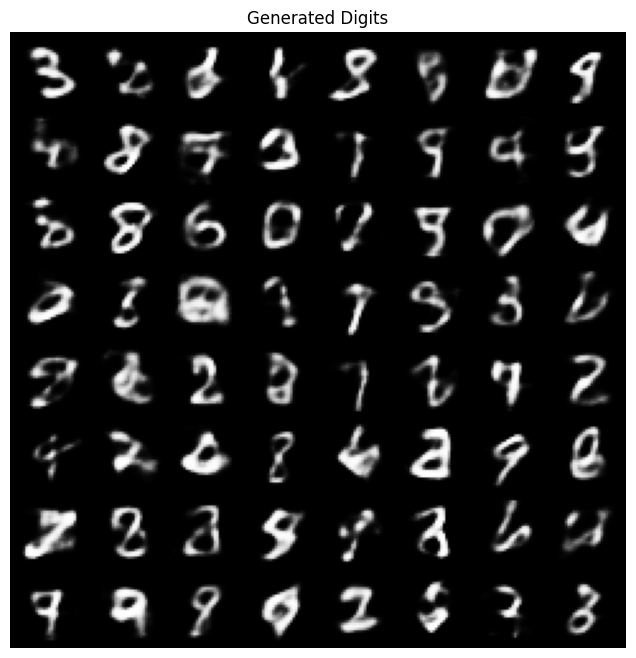

In [10]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu().view(-1, 1, 28, 28)

    grid = torchvision.utils.make_grid(samples, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.title("Generated Digits")
    plt.show()


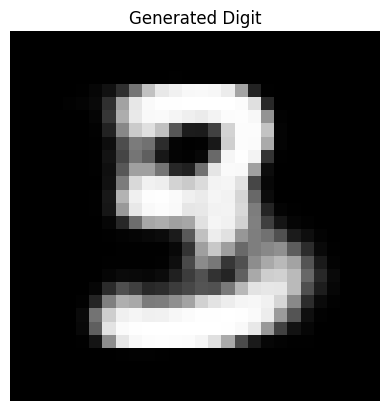

In [12]:
model.eval()
with torch.no_grad():
  z = torch.randn(1, latent_dim).to(device)
  generated=model.decode(z).cpu().view(28,28)
  plt.imshow(generated, cmap="gray")
  plt.title("Generated Digit")
  plt.axis("off")
  plt.show()
